#### Import the necessary python packages

In [246]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import pandas as pd
from scipy import signal

from IPython.display import HTML

%matplotlib inline

In [249]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

# Porosity and Saturation effects on AVO

### Gassmann's Equations
Gassmann's equations (seen below) describes how the bulk modulus of a saturated rock changes as the saturating fluid changes. It provides a useful means for modeling how the seismic response of a formation may change for different filling fluids.

For a discussion of the origin and derivation of Gassmann's equations, see Berryman, 2000 (https://doi.org/10.1190/1.1444667) 

$$\textbf{Gassmann Equations}$$
$$\frac{K_{sat}}{K_{mineral} - K_{sat}} = \frac{K_{dry}}{K_{mineral} - K_{dry}} + \frac{K_{fluid}}{\phi(K_{mineral} - K_{fluid})}$$

$$\mu_{sat} = \mu_{dry}$$

$K_{dry} = \text{Dry rock bulk modulus}$  
$K_{mineral} = \text{Mineral bulk modulus}$  
$K_{sat} = \text{Saturated rock bulk modulus}$  
$K_{fluid} = \text{Fluid bulk modulus}$   
$\mu_{sat} = \text{Shear modulus of the saturated rock}$  
$\mu_{dry} = \text{Shear modulus of the dry rock}$

### Assumptions

1. Porous material is isotropic, elastic, monomineralic, and homogeneous
2. Pore sapce is well connected and in pressure equilibrium
3. Medium is a closed system with no pore fluid movement across boundaries
4. No checmical interaction between fluids and rock frame (i.e. no diagenetic processes)
5. Frequency effects are negligible when considering the measurements. Gassmann's equations are valid only for seismic frequencies (<100 Hz from Mavko, 1998).

These assumptions are often violated in real reservoirs. However, Gassmann's model is still generally the preferred model as it can be easily parameterized. A number of publications exist which suggest ways to modify inputs or assumptions to make these relationships more applicable to more variable rocks. A good general discussion of this can be found in Rob Simm's 2007 article "Practical Gassmann fluid substitution in sand/shale sequences (DOI: 10.3997//1365-2387.2007030).

Below we will look at the Avseth et. al, 2006 fluid substitution workflow, which is used in this notebook.

#### Gassmann fluid substitution recipe from Avseth, 2006$^{[1]}$

$\textbf{Step 1:}$ Extract the dynamic bulk and shear moduli from $V_{p}^{(1)}$, $V_{s}^{(1)}$ , and $\rho^{(1)}$:

$K^{(1)}\ =\ \rho((V_{p}^{(1)})^2 - \frac{4}{3}(V_{s}^{(1)})^2)\\ \mu^{(1)}\ =\ \rho(V_{s}^{(1)})^2$

$\textbf{Step 2:}$ Apply Hassmann's relation to transform the bulk modulus:

$\frac{K_{sat}^{(2)}}{K_{mineral}\ -\ K_{sat}^{(2)}}\ -\ \frac{K_{fluid}^{(2)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(2)})}\ =\ \frac{K_{sat}^{(1)}}{K_{mineral}\ -\ K_{sat}^{(1)}}\ -\ \frac{K_{fluid}^{(1)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(1)})}$

$\textbf{Step 3:}$ Leave the shear modulus unchanged:

$\mu_{sat}^{(1)} = \mu_{sat}^{(2)}$

$\textbf{Step 4:}$ Remember to correct the bulk density for the fluid change:

$\rho^{(2)} = \rho^{(1)} + \phi(\rho_{fluid}^{(2)} - \rho_{fluid}^{(1)})$

$\textbf{Step 5:}$ Reassemble the velocities:

$V_p^{(2)} = \sqrt{\frac{K_{sat}^{(2)} + \frac{4}{3} \mu_{sat}^{(2)}}{\rho^{(2)}}}$

$V_s^{(2)} = \sqrt{\frac{\mu_{sat}^{(2)}}{\rho^{(2)}}}$

Below is a basic, blocked log example of Gassmann fluid substitution to help explore the affects of different fluids on the seismic response.

$^{[1]}$Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Locations 582-584). Cambridge University Press. Kindle Edition. 

### Batzle and Wang fluid calculations

The most common, and likely most useful, method for calcualting the properties of fluids of varying composition, temperature, and pressure are emperical fluid equations from Batzle & Wang 1992. 

These functions take pressure in MPa and temperature in Centigrade. It outputs density in g/cc, velocity in m/s, and bulk modulus (K) in GPa.  

$\textbf{Equations for dead oil:}$

$API = \frac{141.5}{\rho_0} - 131.5$

$\rho_P = \rho_0 + (0.00277P - 1.71 \times 10^{-7}P^3)(\rho_0 - 1.15)^2 + 3.49 \times 10^{-4}P$

$\rho = \rho_P / [0.972 + 3.81 \times 10^{-4}(T + 17.78)^{1.175}]$

$V = 15450(77.1 + API)^{-1/2} - 3.7T + 4.64P + 0.0115(0.36API^{1/2} - 1)TP$



In [4]:
def bwOil(temp,pressure,API, gasGravity,live = False):
    # Pressue in MPa, Temp in C
    P = pressure
    T = temp
    G = gasGravity
    rho0 = 141.5 / (API + 131.5)
    rhoP = rho0 + (0.00277*P - 1.71e-7 * P**3)*(rho0 - 1.15)**2 + 3.49e-4 * P
    
    #Rg = 0.02123*G*(P*np.exp(4.072/rho0 - 0.00377*T))**1.205 # Eqtn 21a
    Rg = 2.03*G*(P*np.exp(0.02878*API - 0.00377*T))**1.205 # Eqtn 21b
    Bo = 0.972 + 0.00038*(2.4 * Rg * np.sqrt(G/rho0) + T + 17.8)**1.175 # Eqtn 23
    rhoPprime = (rho0/Bo) * (1 + 0.001*Rg)**(-1) # Eqtn 22
    
    if live == False:
        rho = rhoP / (0.972 + 3.81e-4 * (T + 17.78)**1.175) #etqn 20
        vp = 15450*(77.1 + API)**(-1/2) - 3.7*T + 4.64*P + 0.0115*(0.36*API**(1/2) - 1)*T*P
    elif live == True:
        rho = (rho0 + 0.0012*G*Rg)/Bo
        vp = 2096 * np.sqrt(rhoPprime/(2.6 - rhoPprime)
                           ) - 3.7*T + 4.64*P + 0.0115*(4.12 * (1.08 * rhoPprime**-1 - 1) - 1)*T*P
    
    K = (rho * vp**2)/1e6
    
    return K, rho

def bwBrine(temp,pressure,salinity):
    # Pressue in MPa, Temp in C, salinity is weight fraction (i.e. ppm/1e6)
    # The velocity is not agreeing with the FPE from CREWES but I can't figure out why

    S = salinity
    P = pressure
    T = temp
    
    #eqtn 27 - 29
    rhow = 1 + 1e-6 * (-80*T - 3.3*T**2 + 0.00175*T**3 + 489*P - 
                      2*T*P + 0.016*T**2 * P - 1.3e-5 * T**3 * P - 
                      0.333*P**2 - 0.002*T*P**2)
    rhobr = rhow + S*(0.668 + 0.44*S + 1e-6 * (300*P - 2400*P*S + 
                                               T*(80 + 3*T - 3300*S - 13*P + 47*P*S)))

    w = np.array([[1402.85, 1.524, 3.437e-3, -1.197e-5],
                 [4.871, -0.0111, 1.739e-4, -1.628e-6],
                 [-0.04783, 2.747e-4, -2.135e-6, 1.237e-8], 
                 [1.487e-4, -6.503e-7, -1.455e-8, 1.327e-10], 
                 [-2.197e-7, 7.987e-10, 5.230e-11, -4.614e-13]], dtype = float)
    
    vpW = np.sum(w[i][j]*np.power(P,[i])*np.power(T,[j]) for i in range(0,4) for j in range(0,3))
    
    vpB = vpW + S*(1170 - 9.6*T + 0.055*T**2 - 8.5e-5 * T**3 + 2.6*P 
                   - 0.0029*T*P - 0.0476*P**2)+ S**1.5 * (780 -10*P + 0.16*P**2) - 820*S**2
    
    K = (rhobr * vpB**2)/1e6
    
    rhobr = np.array(rhobr)
    vpB = np.array(vpB)
    K = np.array(K)
    
    return K, rhobr


### Input data

In [252]:
# Pressure (P), Temperature (T), API, Gas Gravity (G), Salinity weight fraction (S)
P = 100 # MPa
T = 85.5 # degrees C
API = 35
G = 0.6
S = 0.088 # ppm/1e6
f = 30 #frequency of ricker wavelet

# In situ parameters are GOM clean sand 100% brine saturated values
vpInSitu = 3550 # m/s
vsInSitu = 1900 # m/s
rhobInSitu = 2240 # kg/m^3
resThickness = 100 # thickness in meters


KflInitial, rhoflInitial = bwBrine(P,T,0.025) # make up any initial fluid you want
KflBrine, rhoflBrine = bwBrine(P,T,S)
KflOil, rhoflOil = bwOil(P,T,API,G,live = False)
KflGas, rhoflGas = 0.23*1e9, 295 # gas GPa
Kmineral = 37.0*1e9 # Gpa Quartz from tables

# encasing rock properties
vpEncase, vsEncase, rhobEncase = 3350,1700,2500
#3350,1700,2500
#--------------------------------------------------------------------
#--------------------------------------------------------------------

# Some order of magnitude changes to the default outputs
rhoflInitial = rhoflInitial*1e3
rhoflBrine = rhoflBrine*1e3
rhoflOil = rhoflOil*1e3

phi = np.round((2650 - rhobInSitu)/(2650 - rhoflInitial),2) # SS density porosity

KflInitial = KflInitial*1e9
KflBrine = KflBrine*1e9
KflOil = KflOil*1e9
#KflGas = KflGas*1e9
#rhoflGas = rhoflGas

# Wavelet Parameters
wvlt_type = 'ricker'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

# Angle of incidence range
thetaMax = 35

##### Useful functions

In [253]:
def basicFluidSub(vpInSitu,vsInSitu,rhoInSitu,Kmineral,Kfl1,Kfl2,rhofl1,rhofl2):
    
    # From Avseth, 2006 
    # Avseth, Per; Mukerji, Tapan; Mavko, Gary. 
    # Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk
    
    # Step 1: Extract the dynamic bulk and shear moduli from vp, vs, and rhob
    Ksat1 = (rhoInSitu*(vpInSitu**2 - (4/3)*vsInSitu**2)) # put in GPa
    muSat1 = rhoInSitu * vsInSitu**2

    # Step 2: Apply gassma
    sat = Ksat1 / (Kmineral - Ksat1)
    fluid1 = Kfl1 / (phi*(Kmineral - Kfl1))
    fluid2 = Kfl2 / (phi*(Kmineral - Kfl2))
    Ksat2 = Kmineral / ((1/(sat - fluid1 + fluid2)) + 1)
    
    # step 3

    muSat2 = muSat1 # Gassmann formulation shows that the shear modulus is unaffected by fluid changes

    # step 4

    rhob2 = rhoInSitu + phi*(rhofl2 - rhofl1)

    # step 5 
    M = Ksat2 + 4*muSat2 / 3
    vpNew = np.sqrt(M / rhob2)
    vsNew = np.sqrt(muSat2 / rhob2)
    
    return vpNew, vsNew, rhob2

# Full Zoeppritz Rpp and Rps from Aki and Richards 1980 derivation
# Can take an array as input 
def zoeRppRps(vp,vs,rho,thetaMax,RppCalc = True, RpsCalc = True):    
    theta1 = np.radians(np.arange(thetaMax)).astype(complex)
    p = np.sin(theta1) / vp[0]  # Ray parameter
    theta2 = np.arcsin(p * vp[1])
    phi1 = np.arcsin(p * vs[0])  # Reflected S
    phi2 = np.arcsin(p * vs[1])  # Transmitted S

    a = rho[1] * (1 - 2 * np.sin(phi2)**2.) - rho[0] * (1 - 2 * np.sin(phi1)**2.)
    b = rho[1] * (1 - 2 * np.sin(phi2)**2.) + 2 * rho[0] * np.sin(phi1)**2.
    c = rho[0] * (1 - 2 * np.sin(phi1)**2.) + 2 * rho[1] * np.sin(phi2)**2.
    d = 2 * (rho[1] * vs[1]**2 - rho[0] * vs[0]**2)

    E = (b * np.cos(theta1) / vp[0]) + (c * np.cos(theta2) / vp[1])
    F = (b * np.cos(phi1) / vs[0]) + (c * np.cos(phi2) / vs[1])
    G = a - d * np.cos(theta1)/vp[0] * np.cos(phi2)/vs[1]
    H = a - d * np.cos(theta2)/vp[1] * np.cos(phi1)/vs[0]

    D = E*F + G*H*p**2
    
    if RppCalc == True:
        Rpp = (1/D) * (F*(b*(np.cos(theta1)/vp[0]) - c*(np.cos(theta2)/vp[1])) \
                   - H*p**2 * (a + d*(np.cos(theta1)/vp[0])*(np.cos(phi2)/vs[1])))
        return np.real(Rpp)
    if RpsCalc == True:
        Rps = (1/(vs[0]*D)) * (-2*(np.cos(theta1)/vp[0]) * (a*b + c*d*((np.cos(theta2)*np.cos(phi2))/(vp[1]*vs[0]))*p*vp[0]))
        return np.real(Rps),p 
     
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt
    

def calc_times(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int



# Function to create synthetic pre-stack data 
# This only works for the three layer case and needs to be generalized
def prestkGathers(RppTop,RppBase,mSamples,thetaMax,z_int,f):
    
    rcGrid = np.zeros((mSamples, thetaMax))
    
    rcGrid[z_int[1]] = np.array(RppTop)
    rcGrid[z_int[2]] = np.array(RppBase)
    
        #for i in range(1,len(z_int)-1):
        #for j in np.arange(len(RppTop[0])):
        #RppTop = np.array(RppTop).T
            
        
    synth = np.zeros(( mSamples, thetaMax)) # Create an array of dimenions [m-1,n] samples. -1 to match the m-1 sample output 
                                             # from convolve with 'same' flag
    wavelet = signal.ricker(512,1e3/(4.*f))
    wavelet = wavelet / max(wavelet)   # normalize
    for k in range(thetaMax):
        synth[:,k] = signal.convolve(rcGrid[:,k], wavelet,'same')   
    
    return synth

##### Calculations occur here

In [254]:
lyr_times = []

#nlayers = len(vp_mod)
#nint = nlayers - 1

## Generate wavelet
#if wvlt_type == 'ricker':
#    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
#    
#elif wvlt_type == 'bandpass':
#    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)
#
## Apply amplitude scale factor to wavelet (to match seismic amplitude values)
#wvlt_amp = wvlt_scalar * wvlt_amp

# Calculate fluid substituted velocities

fluidSubs = np.array(['Inital (vp,vs,rhob)', 'Brine (vp,vs,rhob)', 'Oil (vp,vs,rhob)', 'Gas (vp,vs,rhob)'])
s=[[] for i in np.arange(len(fluidSubs))]
subProps = pd.Series(s,index = fluidSubs)

vp = []
vs = []
rhob = []
rhofl = np.array([rhoflInitial,rhoflBrine, rhoflOil, rhoflGas])
Kfls = np.array([KflInitial,KflBrine, KflOil, KflGas])

for i in range(1,len(fluidSubs)):
    subProps[0] = (float(vpInSitu), float(vsInSitu), float(rhobInSitu))
    subProps[i] = basicFluidSub(vpInSitu, vsInSitu, rhobInSitu, Kmineral, Kfls[0], Kfls[i], rhofl[0], rhofl[i])
#subProps[0] = (float(vpInSitu), float(vsInSitu), float(rhobInSitu)) # above method messes up in situ params, replace here

RppTop = []
RppBase = []

for i in range(1,len(fluidSubs)):
    vp.append([vpEncase, subProps[i][0],vpEncase])
    vs.append([vsEncase,subProps[i][1],vsEncase])
    rhob.append([rhobEncase,subProps[i][2],rhobEncase])
    
# Calculate reflectivities
RppTop = []
RppBase = []

for i in range(0,len(fluidSubs)-1):
    RppTop.append([zoeRppRps(vp[i],vs[i], rhob[i], thetaMax, RppCalc = True, RpsCalc = False)])
    RppBase.append([zoeRppRps(vp[i][1:],vs[i][1:],rhob[i][1:], thetaMax, RppCalc = True, RpsCalc = False)])
    
RppBrine = np.array(RppTop[0]).T
RppOil = np.array(RppTop[0]).T
RppGas = np.array(RppTop[0]).T

# Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)

# Calculate interface depths
z_int = [0,500]
z_int.append(z_int[1] + resThickness)

# curve plots in depth
# make lists of three arrays to hold each fluid subbed curve

vpCurve = []
vsCurve = []
rhoCurve = []

for i in range(0,len(vp)):
    vpCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
    vsCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
    rhoCurve.append(np.array(np.zeros(z_int[1]*2 + resThickness)))
# Convert into arrays to make them easier to work with    
vpCurve = np.array(vpCurve)
vsCurve = np.array(vsCurve)
rhobCurve = np.array(rhoCurve)
    
for i in np.arange(len(z_int)):
    vpCurve[0][z_int[i]:] = vp[0][i] # this is close but not there yet
    vpCurve[1][z_int[i]:] = vp[1][i]
    vpCurve[2][z_int[i]:] = vp[2][i]
    vsCurve[0][z_int[i]:] = vs[0][i]
    vsCurve[1][z_int[i]:] = vs[1][i]
    vsCurve[2][z_int[i]:] = vs[2][i]
    rhobCurve[0][z_int[i]:] = rhob[0][i]
    rhobCurve[1][z_int[i]:] = rhob[1][i]
    rhobCurve[2][z_int[i]:] = rhob[2][i]
    
# Calc intercept and gradient
ones = np.ones(thetaMax)
ones = ones.reshape((thetaMax,1))

sintheta2 = np.sin(np.radians(np.arange(0, thetaMax)))**2
sintheta2 = sintheta2.reshape((thetaMax, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
IGzoep = np.array([])
for i in np.arange(len(RppTop)):
    IGzoep = np.append(IGzoep,np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), np.array(RppTop[i]).T))

IGzoep = np.split(IGzoep,3)    

# Calculate interface times

#t_int = calc_times(z_int[i:], vp[0])
#lyr_times.append(t_int)

# Digitize 3-layer model
#syn_zoep_pp = []
#for i in range(0,thetaMax):
#    rc = digitize_model(rc_zpp[i], t_int, t)
#    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
#    syn_buf = list(syn_buf)
#    syn_zoep_pp.append(syn_buf)

#### Plot it all up

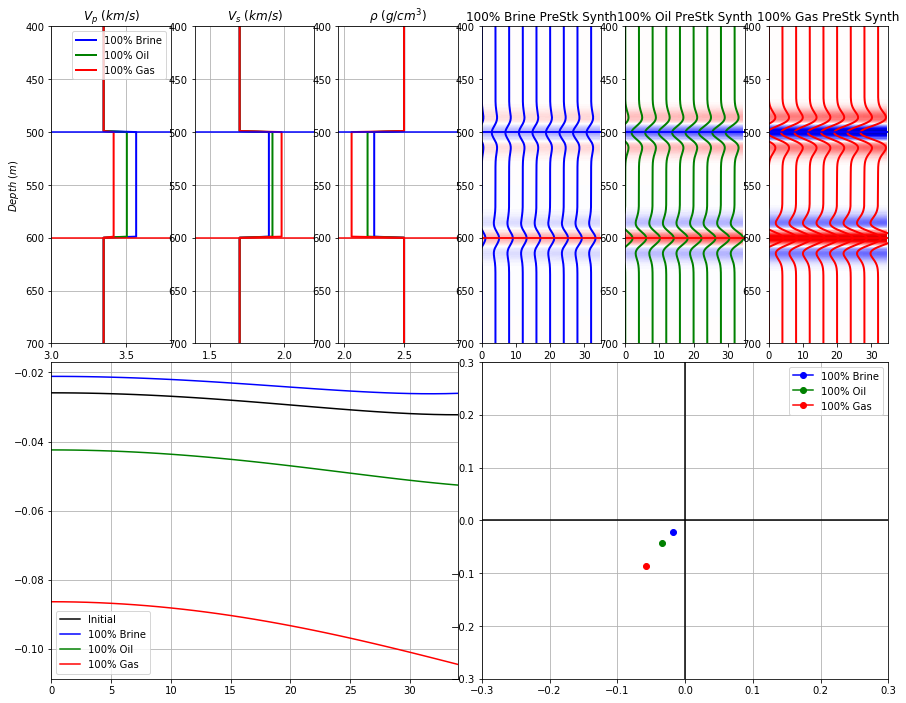

In [255]:
plt.figure(figsize = (15,12))

ax1 = plt.subplot2grid((6, 6), (0, 0), colspan=1, rowspan = 3)
ax2 = plt.subplot2grid((6, 6), (0, 1), colspan = 1, rowspan = 3)
ax3 = plt.subplot2grid((6, 6), (0, 2), colspan = 1, rowspan = 3)
ax4 = plt.subplot2grid((6, 6), (3, 0), colspan = 3, rowspan = 3)
ax5 = plt.subplot2grid((6, 6), (0, 3), colspan=1, rowspan = 3)
ax6 = plt.subplot2grid((6, 6), (0, 4), colspan=1, rowspan = 3)
ax7 = plt.subplot2grid((6, 6), (0, 5), colspan=1, rowspan = 3)
ax8 = plt.subplot2grid((6, 6), (3, 3), colspan = 3, rowspan = 3)

ax = [ax5,ax6, ax7]

plt.figure(figsize=(10,5))
color = ['b','g','r']
labels = ['100% Brine', '100% Oil', '100% Gas']
titles = ['100% Brine PreStk Synth', '100% Oil PreStk Synth', '100% Gas PreStk Synth']

for i in range(0,len(vpCurve)):
    ax1.plot(vpCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2, label = labels[i])
ax1.set_xlim(3,3.8)
ax1.set_ylim(z_int[1]-100,z_int[2]+100)
ax1.set_title(r'$V_p\ (km/s)$')
ax1.set_ylabel(r'$Depth\ (m)$')
ax1.axhline(z_int[1],color = 'b')
ax1.axhline(z_int[2],color = 'r')
ax1.grid()
ax1.invert_yaxis()
ax1.legend(loc = 1)

for i in range(0,len(vpCurve)):
    ax2.plot(vsCurve[i]/1000, np.arange(len(vsCurve[0]/1000)), color = color[i],linewidth = 2)
ax2.set_xlim(1.4,2.2)
ax2.set_ylim(z_int[1]-100,z_int[2]+100)
ax2.set_title(r'$V_s\ (km/s)$')
ax2.axhline(z_int[1],color = 'b')
ax2.axhline(z_int[2],color = 'r')
ax2.grid()
ax2.invert_yaxis()

for i in range(0,len(vpCurve)):
    ax3.plot(rhobCurve[i]/1000, np.arange(len(vpCurve[0]/1000)), color = color[i],linewidth = 2)
ax3.set_xlim(1.95,2.95)
ax3.set_ylim(z_int[1]-100,z_int[2]+100)
ax3.set_title(r'$\rho \ (g/cm^3)$')
ax3.axhline(z_int[1],color = 'b')
ax3.axhline(z_int[2],color = 'r')
ax3.grid()
ax3.invert_yaxis()

ax4.plot(zoeRppRps([vpEncase, vpInSitu], [vsEncase, vsInSitu], [rhobEncase, rhobInSitu], thetaMax), 'k-', label = 'Initial')
for i in range(0,len(vpCurve)):
    ax4.plot(np.array(RppTop[i]).T,color=color[i], label = labels[i])
ax4.set_xlim(0,thetaMax-1)
ax4.grid()
ax4.legend()

for i in np.arange(3):
    ax[i].imshow(prestkGathers(RppTop[i],RppBase[i],np.sum(z_int),thetaMax,z_int,30),
                 cmap = 'seismic',vmin = -0.15,vmax=0.15, aspect = 'auto')
    ax[i].axhline(z_int[1],color = 'b')
    ax[i].axhline(z_int[2],color = 'r')
    ax[i].set_ylim(z_int[1]-100,z_int[2]+100)
    ax[i].invert_yaxis()
    ax[i].set_title(titles[i])

gap = int(np.round(thetaMax/10)) # distance to shift wiggles
nwigs = np.round(thetaMax/gap) # number of wiggles
g = 50 # gain
tick_spacing = 10 # angle ticket spacing

for i in np.arange(3):
    for j in np.arange(int(nwigs)):
        synth = prestkGathers(RppTop[i],RppBase[i],np.sum(z_int),thetaMax,z_int,f)
        synth = (synth.T[::gap]).T
        ax[i].plot(synth[:,j]*g+j*gap,np.arange(len(synth)), color=color[i],lw=2) 
        #ax[i].fill_betweenx(np.arange(len(synth)),synth[:,j]*g+i*gap, i*gap, synth[:,j]*g+i*gap > i*gap, color='k', alpha=1.0) 
    ax[i].axhline(z_int[1],color = 'b')
    ax[i].axhline(z_int[2],color = 'r')
    ax[i].set_ylim(z_int[1]-100,z_int[2]+100)
    ax[i].set_xlim(0,thetaMax)
    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax[i].invert_yaxis()
    ax[i].set_title(titles[i])
    
for i in np.arange(len(IGzoep)):
    ax8.plot(IGzoep[i][1],IGzoep[i][0], color = color[i],marker = 'o',label=labels[i])
ax8.set_xlim(-0.3,0.3)
ax8.set_ylim(-0.3,0.3)
ax8.axvline(0,color='k')
ax8.axhline(0,color='k')
ax8.grid()
ax8.legend()


#ax5.imshow(test[0], cmap = 'seismic', aspect = 'auto')
#ax5.axhline(z_int[1],color = 'b')
#ax5.axhline(z_int[2],color = 'r')
#ax5.set_ylim(z_int[1]-100,z_int[2]+100)
#ax5.invert_yaxis()

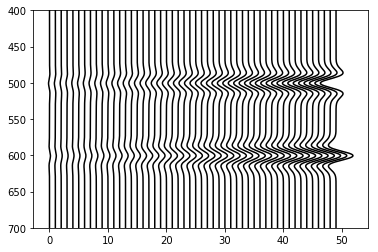

In [221]:
gap = 1
nwigs = np.round(thetaMax/gap)
g = 20 # gain

#testSynth = prestkGathers(RppTop[1],RppBase[1],np.sum(z_int),thetaMax,z_int,30)
#testSynth = (testSynth.T[::gap]).T


for i in np.arange(len(testSynth[0])):
    plt.plot(testSynth[:,i]*g+i*gap,np.arange(len(testSynth)), 'k')
    #plt.fill_betweenx(np.arange(len(testSynth[0]),testSynth[:,i]*g+i*gap > i*gap))
plt.ylim(400,700)
plt.gca().invert_yaxis()